In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.metrics import confusion_matrix
import os
from google.colab import files

In [6]:
SEED = 20240102
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

if not os.path.exists('results'):
    os.makedirs('results')

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

classes = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

In [8]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(128, 10)
        )
    def forward(self, x):
        x = self.block1(x)
        x = self.block2(x)
        x = self.classifier(x)
        return x


In [9]:
def train_model(learning_rate, batch_size, epochs=10):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Training on: {device}")
    model = FashionCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    history = {'train_loss': [], 'test_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()


        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        acc = 100 * correct / total
        history['train_loss'].append(running_loss / len(train_loader))
        history['test_acc'].append(acc)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {running_loss/len(train_loader):.4f}, Acc: {acc:.2f}%')

    return model, history


In [10]:
print("VERSION 1")
model1, history1 = train_model(learning_rate=0.001, batch_size=64)

print("VERSION 2")
model2, history2 = train_model(learning_rate=0.0001, batch_size=64)

VERSION 1
Training on: cuda
Epoch [1/10], Loss: 0.5213, Acc: 87.99%
Epoch [2/10], Loss: 0.3468, Acc: 89.56%
Epoch [3/10], Loss: 0.2963, Acc: 90.13%
Epoch [4/10], Loss: 0.2659, Acc: 90.49%
Epoch [5/10], Loss: 0.2414, Acc: 91.11%
Epoch [6/10], Loss: 0.2224, Acc: 91.03%
Epoch [7/10], Loss: 0.2093, Acc: 91.61%
Epoch [8/10], Loss: 0.1941, Acc: 91.80%
Epoch [9/10], Loss: 0.1836, Acc: 92.10%
Epoch [10/10], Loss: 0.1768, Acc: 92.02%
VERSION 2
Training on: cuda
Epoch [1/10], Loss: 0.7380, Acc: 83.13%
Epoch [2/10], Loss: 0.4746, Acc: 85.53%
Epoch [3/10], Loss: 0.4133, Acc: 87.29%
Epoch [4/10], Loss: 0.3784, Acc: 87.36%
Epoch [5/10], Loss: 0.3521, Acc: 87.61%
Epoch [6/10], Loss: 0.3338, Acc: 88.83%
Epoch [7/10], Loss: 0.3200, Acc: 88.99%
Epoch [8/10], Loss: 0.3083, Acc: 89.20%
Epoch [9/10], Loss: 0.2962, Acc: 89.53%
Epoch [10/10], Loss: 0.2889, Acc: 89.90%


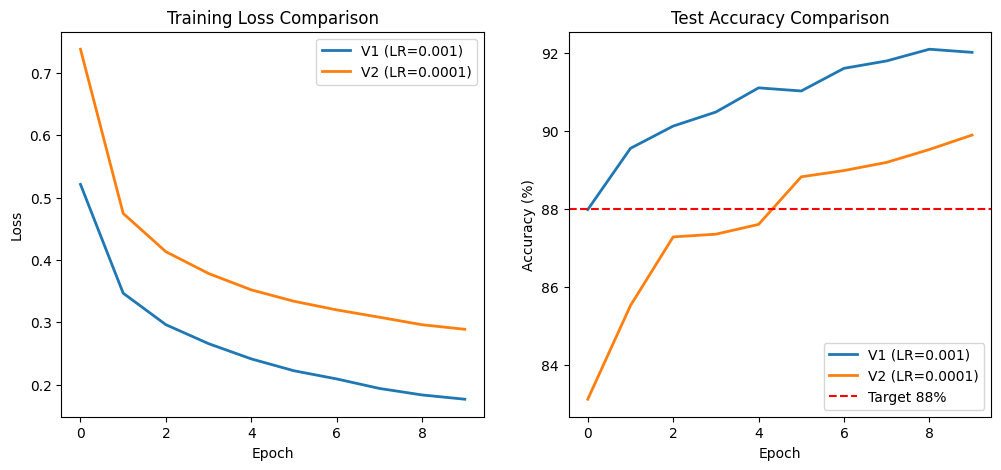

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history1['train_loss'], label='V1 (LR=0.001)', linewidth=2)
plt.plot(history2['train_loss'], label='V2 (LR=0.0001)', linewidth=2)
plt.title('Training Loss Comparison')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history1['test_acc'], label='V1 (LR=0.001)', linewidth=2)
plt.plot(history2['test_acc'], label='V2 (LR=0.0001)', linewidth=2)
plt.axhline(y=88, color='r', linestyle='--', label='Target 88%')
plt.title('Test Accuracy Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.savefig('results/training_comparison.png')
plt.show()

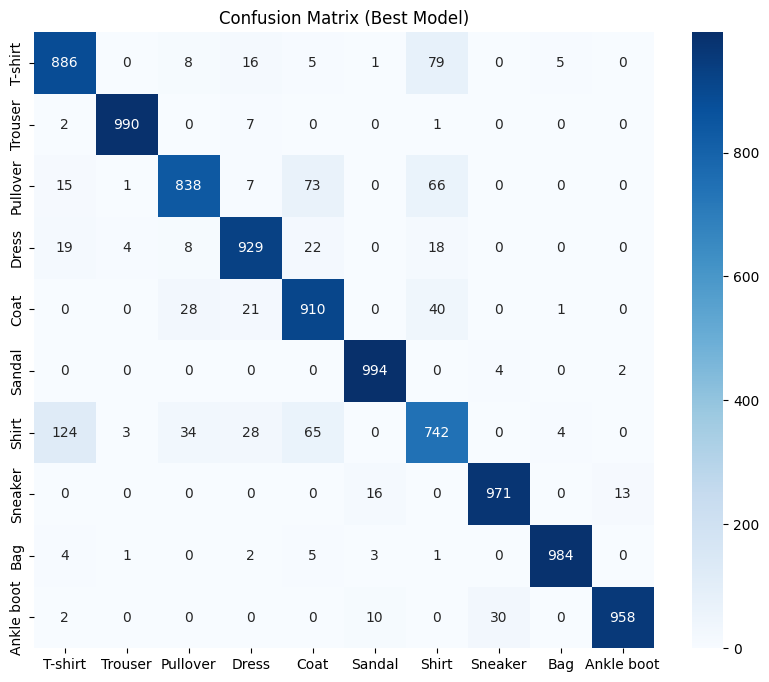

In [12]:
best_model = model1 if history1['test_acc'][-1] > history2['test_acc'][-1] else model2
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
best_model.eval()

all_preds, all_labels = [], []
with torch.no_grad():
    for images, labels in DataLoader(test_dataset, batch_size=64):
        images = images.to(device)
        outputs = best_model(images)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

plt.figure(figsize=(10, 8))
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=classes, yticklabels=classes)
plt.title('Confusion Matrix (Best Model)')
plt.savefig('results/confusion_matrix.png')
plt.show()

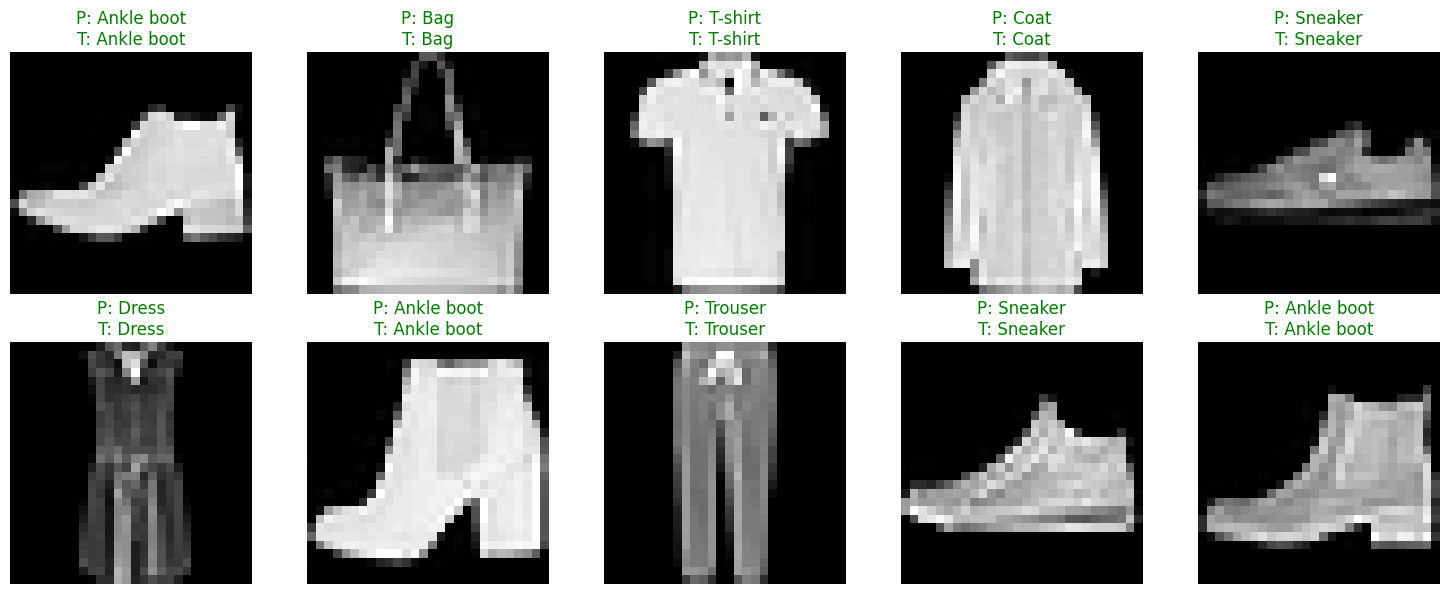

In [13]:
plt.figure(figsize=(15, 6))
indices = np.random.choice(len(test_dataset), 10, replace=False)
for i, idx in enumerate(indices):
    image, label = test_dataset[idx]
    output = best_model(image.unsqueeze(0).to(device))
    _, pred = torch.max(output, 1)

    plt.subplot(2, 5, i+1)
    plt.imshow(image.squeeze(), cmap='gray')
    color = 'green' if pred.item() == label else 'red'
    plt.title(f"P: {classes[pred.item()]}\nT: {classes[label]}", color=color)
    plt.axis('off')
plt.tight_layout()
plt.savefig('results/predictions.png')
plt.show()